## Blood Cell Image Classification 

Given *images of blood cells*, let's try to predict the **type of cell** present in a given image.

We will use a tensorflow pretrained CNN model to make our predictions. 

Data source: https://www.kaggle.com/datasets/paultimothymooney/blood-cells

### Getting Started

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

In [7]:
train_dir = "../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/"
test_dir = "../input/blood-cells/dataset2-master/dataset2-master/images/TEST/"

### Loading Image Dataset

In [8]:
# Create the generators
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
# Flow image data
train_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


### Build Pretrained Model

In [10]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable=False

### Build Classification Model

In [11]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


### Training

In [13]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.9796 - loss: 0.0676 - val_accuracy: 0.9296 - val_loss: 0.1844
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9903 - loss: 0.0409 - val_accuracy: 0.9311 - val_loss: 0.1927
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.9912 - loss: 0.0404 - val_accuracy: 0.8984 - val_loss: 0.2794
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.9927 - loss: 0.0331 - val_accuracy: 0.9372 - val_loss: 0.1762
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9971 - loss: 0.0192 - val_accuracy: 0.9351 - val_loss: 0.1774
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.9982 - loss: 0.0170 - val_accuracy: 0.9211 - val_loss: 0.2273
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.9995 - loss: 0.0142 - val_accuracy: 0.9020 - val_loss: 0.3102


In [15]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", "value": "Loss"},
    title="Training and Validation Loss over Time"
)
fig.show()

### Results

In [17]:
CLASS_NAMES = list(train_images.class_indices.keys())
CLASS_NAMES

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step
Test Accuracy: 50.221%


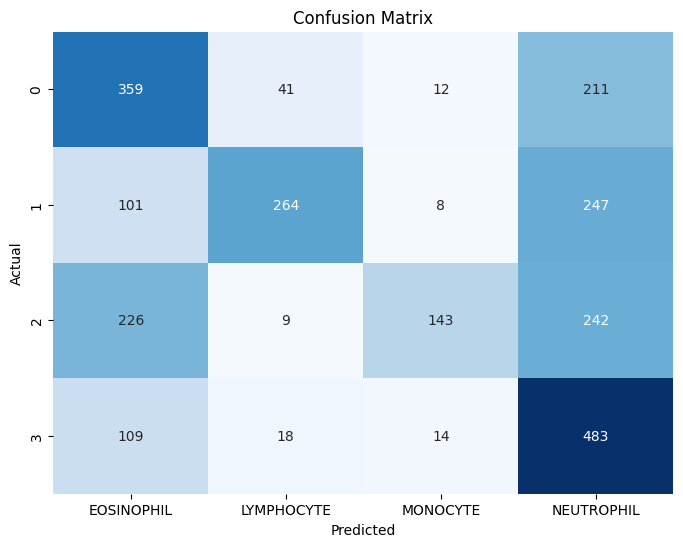

Classification Report:
---------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.45      0.58      0.51       623
  LYMPHOCYTE       0.80      0.43      0.55       620
    MONOCYTE       0.81      0.23      0.36       620
  NEUTROPHIL       0.41      0.77      0.53       624

    accuracy                           0.50      2487
   macro avg       0.62      0.50      0.49      2487
weighted avg       0.62      0.50      0.49      2487



In [20]:
predictions = np.argmax(model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
clf = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)
print("Test Accuracy: {:.3f}%".format(acc*100))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n---------------------------\n", clf)